In [281]:
# Load dataset
import pandas as pd
df = pd.read_csv("dataset_processed.csv")
df = df[['Date','Arrangement', 'Room Type', 'Average Room Rate', 'Occupancy Rate', 'Is_Holiday', 'Is_Weekend', 'Is_Event', 'Is_SchoolHoliday']]
df['Arrangement'] = df['Arrangement'].str.replace('RBT', 'RB')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               2179 non-null   object 
 1   Arrangement        2179 non-null   object 
 2   Room Type          2179 non-null   object 
 3   Average Room Rate  2179 non-null   float64
 4   Occupancy Rate     2179 non-null   float64
 5   Is_Holiday         2179 non-null   bool   
 6   Is_Weekend         2179 non-null   bool   
 7   Is_Event           2179 non-null   bool   
 8   Is_SchoolHoliday   2179 non-null   bool   
dtypes: bool(4), float64(2), object(3)
memory usage: 93.8+ KB


,Date,Arrangement,Room Type,Average Room Rate,Occupancy Rate,Is_Holiday,Is_Weekend,Is_Event,Is_SchoolHoliday
0,2024-01-01,RB,Deluxe,1.035475e+06,0.633333,True,False,False,False
1,2024-01-01,RO,Deluxe,5.672185e+05,0.633333,True,False,False,False
2,2024-01-01,RB,Executive Suite,2.136355e+06,0.633333,True,False,False,False
3,2024-01-02,RB,Deluxe,8.335923e+05,0.622222,False,False,False,False
4,2024-01-02,RO,Deluxe,5.962271e+05,0.622222,False,False,False,False
...,...,...,...,...,...,...,...,...,...
2174,2025-08-30,RO,Deluxe,8.307490e+05,0.571429,False,True,False,False
2175,2025-08-30,RB,Executive Suite,1.900109e+06,0.571429,False,True,False,False
2176,2025-08-31,RB,Deluxe,8.043740e+05,0.347826,False,True,False,False
2177,2025-08-31,RO,Deluxe,7.313615e+05,0.347826,False,True,False,False


# enrich dataset

In [267]:
# enrich dataset
import numpy as np
enrich = df.copy()
#Is_Holiday Is_Weekend Is_Event Is_SchoolHoliday are first, group by date, occupancy rate, we do not need Average Room Rate
enrich = enrich.groupby(['Date', 'Occupancy Rate', 'Is_Holiday', 'Is_Weekend', 'Is_Event', 'Is_SchoolHoliday']).agg({'Average Room Rate': 'mean'}).reset_index()
enrich = enrich.drop(columns=['Average Room Rate'])
enrich = enrich.rename(columns={'Is_Holiday': 'Is_NationalHoliday'})
enrich = enrich.sort_values('Date').reset_index(drop=True)

seed_hol = (enrich['Is_NationalHoliday'].astype(bool) | enrich['Is_Weekend'].astype(bool)).to_numpy()
n = len(seed_hol)

left_seed  = np.r_[False, seed_hol[:-1]]
right_seed = np.r_[seed_hol[1:], False]
is_bridge = (~seed_hol) & left_seed & right_seed
enrich['Is_Bridge'] = is_bridge

is_nat   = enrich['Is_NationalHoliday'].to_numpy(dtype=bool)
is_we    = enrich['Is_Weekend'].to_numpy(dtype=bool)
is_br    = enrich['Is_Bridge'].to_numpy(dtype=bool)

left_hol_final_seed  = np.r_[False, (is_nat | is_br)[:-1]]
right_hol_final_seed = np.r_[(is_nat | is_br)[1:], False]
weekend_adjacent = is_we & (left_hol_final_seed | right_hol_final_seed)

is_holiday_final = is_nat | is_br | weekend_adjacent
enrich['Is_Holiday'] = is_holiday_final

block_id = (~is_holiday_final).cumsum() 
enrich['Holiday_Duration'] = 0
enrich['Days_of_Holiday'] = 0

mask = is_holiday_final
grp = pd.Series(block_id[mask]).groupby(block_id[mask])
sizes = grp.transform('size').to_numpy()

order_in_block = grp.cumcount() + 1

enrich.loc[mask, 'Holiday_Duration'] = sizes
enrich.loc[mask, 'Days_of_Holiday']  = order_in_block.to_numpy()

# Ambil array boolean hari libur (sudah termasuk bridge, sesuai definisi Anda)
is_hol = enrich["Is_Holiday"].to_numpy(dtype=bool)
n = len(enrich)
INF = 10**9

# Sweep ke depan (jarak dari libur terakhir)
dist_fwd = np.full(n, INF, dtype=int)
last = -INF
for i in range(n):
    if is_hol[i]:
        last = i
    dist_fwd[i] = i - last

# Sweep ke belakang (jarak ke libur berikutnya)
dist_bwd = np.full(n, INF, dtype=int)
last = INF
for i in range(n - 1, -1, -1):
    if is_hol[i]:
        last = i
    dist_bwd[i] = last - i

# Ambil jarak minimum; hari libur = 0
dist = np.minimum(dist_fwd, dist_bwd)
dist[is_hol] = 0
enrich["Distance_to_Holiday"] = dist

enrich['Day_of_Week']  = pd.to_datetime(enrich['Date']).dt.dayofweek
enrich['Day_of_Month'] = pd.to_datetime(enrich['Date']).dt.day
enrich['Month']        = pd.to_datetime(enrich['Date']).dt.month
enrich['Year']         = pd.to_datetime(enrich['Date']).dt.year

enrich

,Date,Occupancy Rate,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year
0,2024-01-01,0.633333,True,False,False,False,False,True,1,1,0,0,1,1,2024
1,2024-01-02,0.622222,False,False,False,False,False,False,0,0,1,1,2,1,2024
2,2024-01-03,0.678161,False,False,False,False,False,False,0,0,2,2,3,1,2024
3,2024-01-04,0.651685,False,False,False,False,False,False,0,0,3,3,4,1,2024
4,2024-01-05,0.703297,False,False,False,False,False,False,0,0,4,4,5,1,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,2025-08-27,0.774194,False,False,True,False,False,False,0,0,9,2,27,8,2025
605,2025-08-28,0.806452,False,False,True,False,False,False,0,0,10,3,28,8,2025
606,2025-08-29,0.793478,False,False,False,False,False,False,0,0,11,4,29,8,2025
607,2025-08-30,0.571429,False,True,False,False,False,False,0,0,12,5,30,8,2025


R² test: 0.45143710347978805
Test R²=0.451 | MAE=0.119 | RMSE=0.148 | MAPE=25.188%


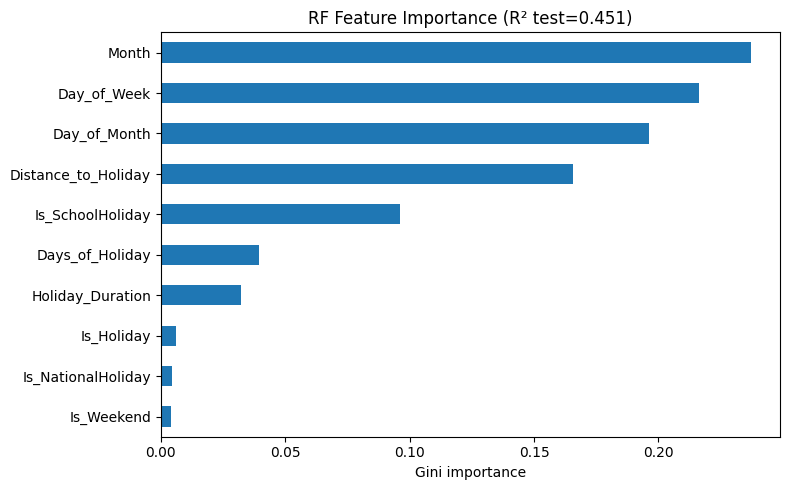

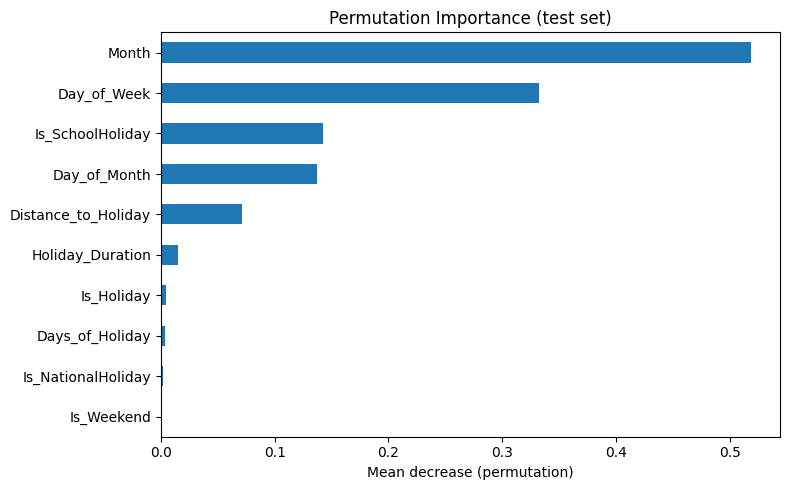

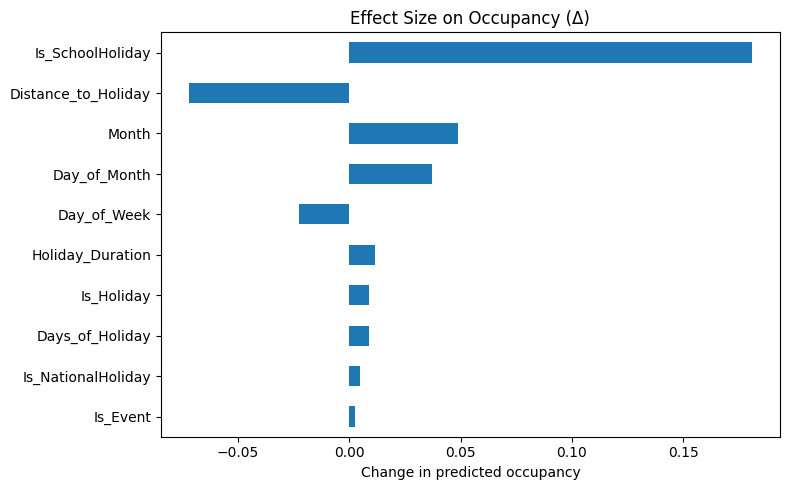

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 8 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


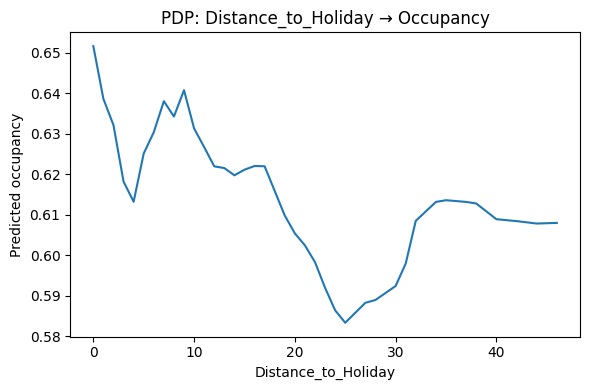

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 6 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


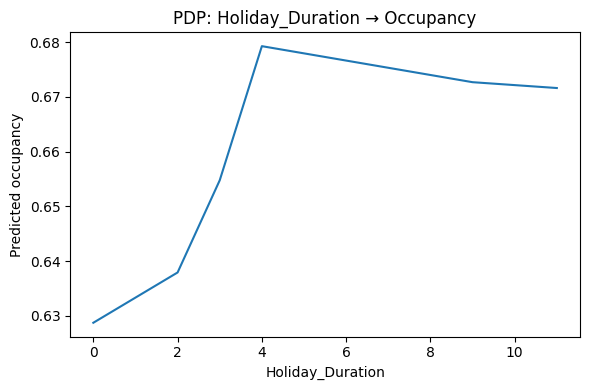

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 7 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


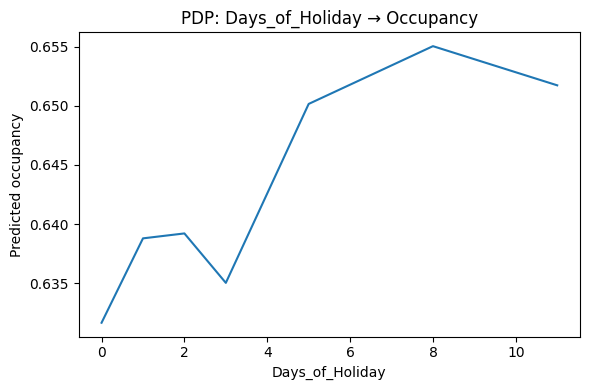

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 9 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


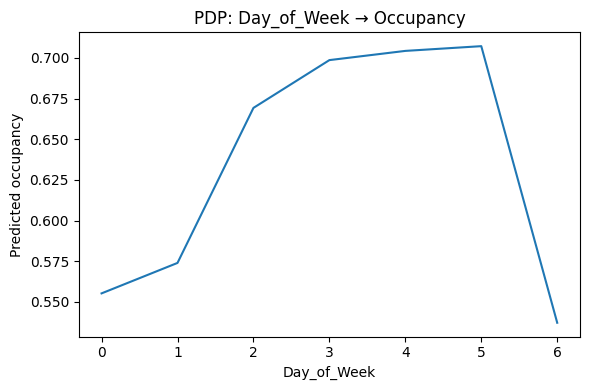

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


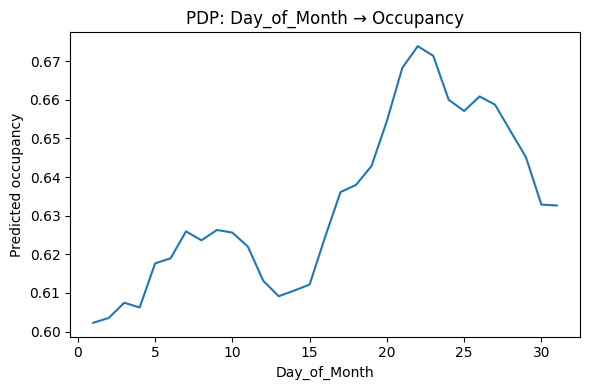

In [268]:
# Make a RF to see how independent affecting Occupancy Rate (ALL)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rfset = enrich.copy()

target = 'Occupancy Rate'
drop_cols = ["Date", "Year", target]
X = rfset.drop(columns=drop_cols).copy()
y = rfset[target].astype(float).clip(1e-6, 1-1e-6)

for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)
    if X[c].dtype == object and set(pd.unique(X[c])) <= {"True","False"}:
        X[c] = X[c].map({"False":0, "True":1}).astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, shuffle=True
    )

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=0,
    min_samples_leaf=2, 
    n_jobs=-1
    )

rf.fit(X_tr, y_tr)
r2_test = r2_score(y_te, rf.predict(X_te))
print("R² test:", r2_test)

y_pred = rf.predict(X_te)

r2  = r2_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
mape= (np.abs((y_te - y_pred) / np.maximum(y_te, 1e-6))).mean()

print(f"Test R²={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f} | MAPE={mape:.3%}")

fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
perm = permutation_importance(rf, X_te, y_te, n_repeats=8, random_state=0, n_jobs=-1)
pi = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

def barplot(series, title, xlabel):
    top = series.head(10)
    plt.figure(figsize=(8,5))
    top[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

barplot(fi, f"RF Feature Importance (R² test={r2_score(y_te, rf.predict(X_te)):.3f})", "Gini importance")
barplot(pi, "Permutation Importance (test set)", "Mean decrease (permutation)")

def binary_effect(model, Xtest, col):
    X0 = Xtest.copy(); X0[col] = 0
    X1 = Xtest.copy(); X1[col] = 1
    return float(model.predict(X1).mean() - model.predict(X0).mean())

binary_cols = [c for c in X.columns if set(pd.unique(X[c])).issubset({0,1})]
bin_eff = {c: binary_effect(rf, X_te, c) for c in binary_cols}

def numeric_effect_quantile(model, Xtest, col, q_low=0.10, q_high=0.90):
    Xlo, Xhi = Xtest.copy(), Xtest.copy()
    lo, hi = np.percentile(Xtest[col], q_low*100), np.percentile(Xtest[col], q_high*100)
    Xlo[col] = lo
    Xhi[col] = hi
    return float(model.predict(Xhi).mean() - model.predict(Xlo).mean())

num_cols = [c for c in X.columns if set(pd.unique(X[c])).issubset({0,1}) is False]
num_eff  = {c: numeric_effect_quantile(rf, X_te, c) for c in num_cols}

effect = pd.Series({**bin_eff, **num_eff}).sort_values(key=lambda s: s.abs(), ascending=False)
barplot(effect, "Effect Size on Occupancy (Δ)", "Change in predicted occupancy")

def pdp1d_plot(model, Xref, col):
    idx = list(Xref.columns).index(col)
    pdp = partial_dependence(model, Xref, [idx], kind="average")
    xs = pdp.get("grid_values", pdp.get("values"))[0]
    ys = pdp["average"][0]
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys)
    plt.title(f"PDP: {col} → Occupancy")
    plt.xlabel(col); plt.ylabel("Predicted occupancy")
    plt.tight_layout(); plt.show()

for col in ["Distance_to_Holiday","Holiday_Duration", "Days_of_Holiday", "Day_of_Week", "Day_of_Month"]:
    if col in X.columns:
        pdp1d_plot(rf, X_te, col)

R² test: 0.40149587217653604
Test R²=0.401 | MAE=0.108 | RMSE=0.133 | MAPE=19.629%


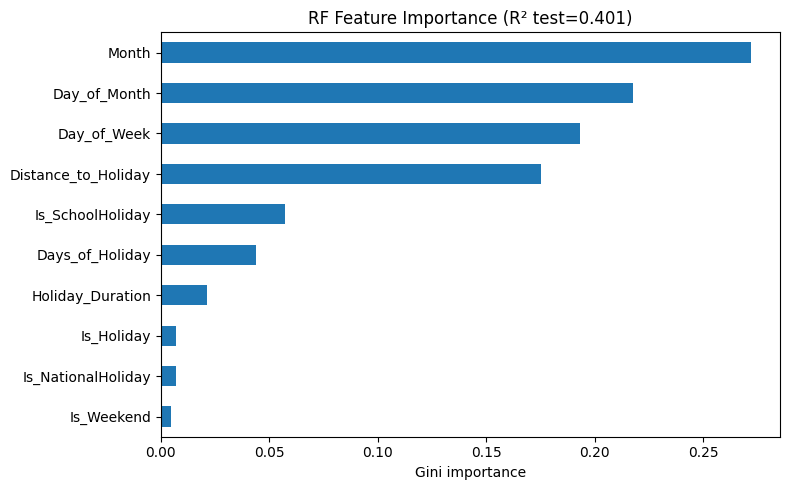

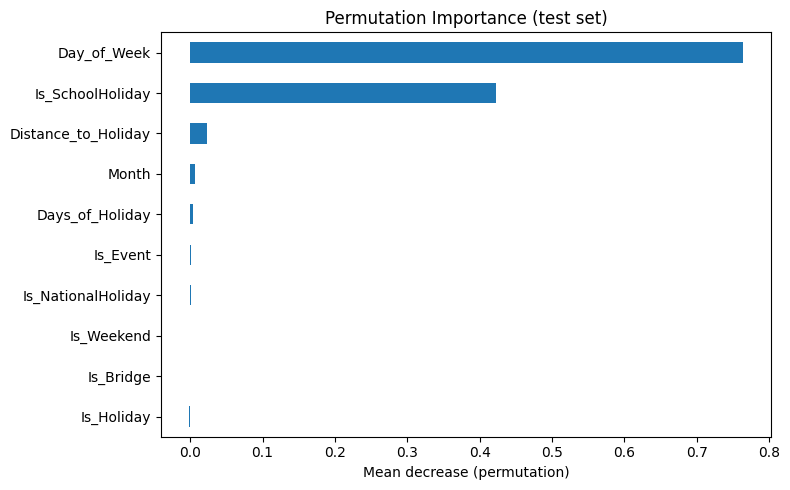

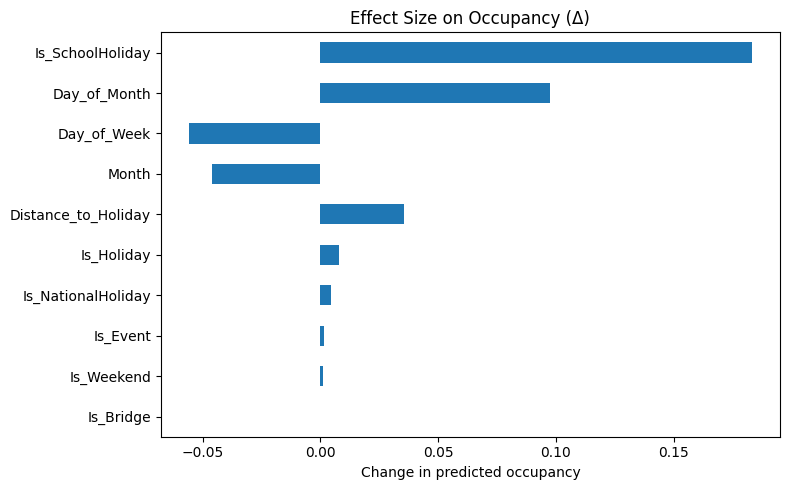

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 8 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


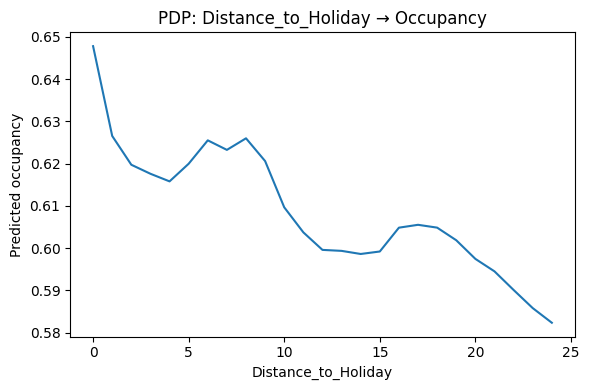

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 6 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


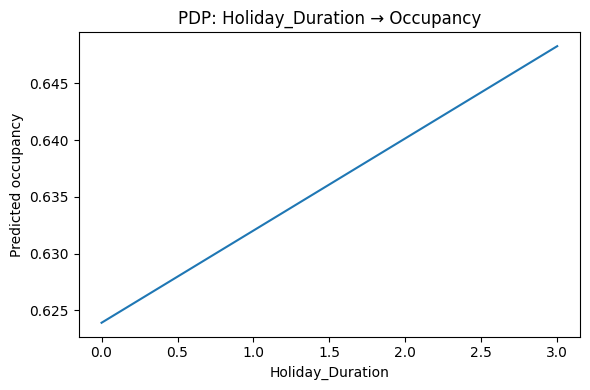

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 7 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


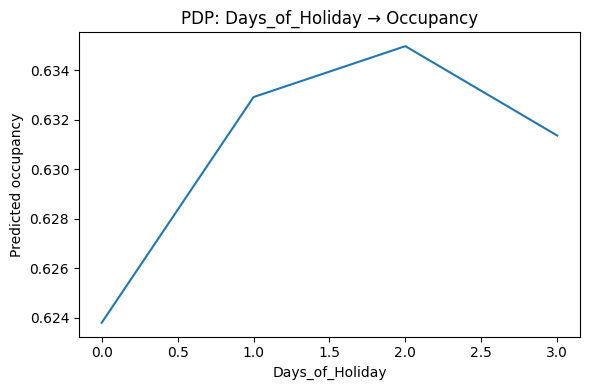

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 9 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


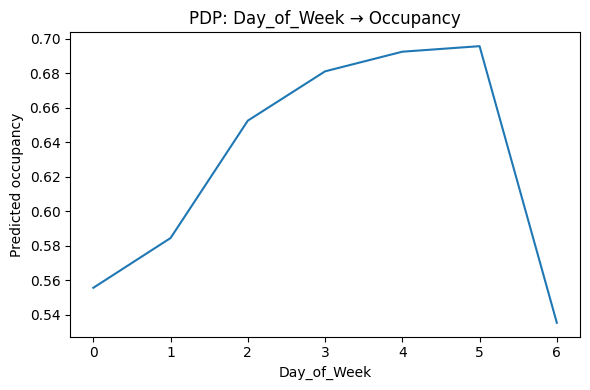

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


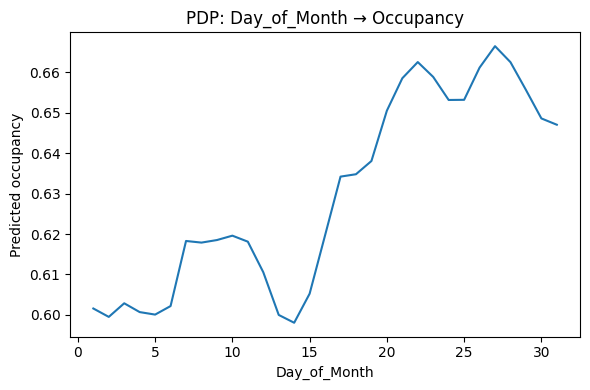

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [269]:
# Make a RF to see how independent affecting Occupancy Rate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import X_DTYPE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rfset = enrich.sort_values('Date').copy()

target = 'Occupancy Rate'
drop_cols = ["Date", "Year", target]

# Split train and test (train 2024 - Juni 2025, test Juli 2025 - Agustus 2025)
train = enrich[enrich['Date'] < '2025-07-01'].copy()
test = enrich[enrich['Date'] >= '2025-07-01'].copy()

features = [c for c in rfset.columns if c not in drop_cols]


X_tr, y_tr = train[features].copy(), train[target].astype(float).clip(1e-6, 1-1e-6)
X_te,  y_te  = test[features].copy(),  test[target].astype(float).clip(1e-6, 1-1e-6)

def clean_bool(df):
    for c in df.columns:
        if df[c].dtype == bool:
            df[c] = df[c].astype(int)
        elif df[c].dtype == object:
            uniq = set(pd.unique(df[c].dropna()))
            if uniq <= {"True","False"}:
                df[c] = df[c].map({"False":0, "True":1}).astype("Int64").fillna(0).astype(int)
    return df

X_tr = clean_bool(X_tr)
X_te  = clean_bool(X_te)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=0,
    min_samples_leaf=2, 
    n_jobs=-1
    )
rf.fit(X_tr, y_tr)

r2_test = r2_score(y_te, rf.predict(X_te))
print("R² test:", r2_test)

y_pred = rf.predict(X_te)

r2  = r2_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
mape= (np.abs((y_te - y_pred) / np.maximum(y_te, 1e-6))).mean()

print(f"Test R²={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f} | MAPE={mape:.3%}")

fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
perm = permutation_importance(rf, X_te, y_te, n_repeats=8, random_state=0, n_jobs=-1)
pi = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)

def barplot(series, title, xlabel):
    top = series.head(10)
    plt.figure(figsize=(8,5))
    top[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

barplot(fi, f"RF Feature Importance (R² test={r2_score(y_te, rf.predict(X_te)):.3f})", "Gini importance")
barplot(pi, "Permutation Importance (test set)", "Mean decrease (permutation)")

def binary_effect(model, Xtest, col):
    X0 = Xtest.copy(); X0[col] = 0
    X1 = Xtest.copy(); X1[col] = 1
    return float(model.predict(X1).mean() - model.predict(X0).mean())

# gunakan X_te, bukan X
binary_cols = [c for c in X_te.columns if set(pd.unique(X_te[c])).issubset({0,1})]
bin_eff = {c: binary_effect(rf, X_te, c) for c in binary_cols}

def numeric_effect_quantile(model, Xtest, col, q_low=0.10, q_high=0.90):
    Xlo, Xhi = Xtest.copy(), Xtest.copy()
    lo, hi = np.percentile(Xtest[col], q_low*100), np.percentile(Xtest[col], q_high*100)
    if lo == hi:     # kalau varians kolom sangat kecil / konstan di test
        return 0.0
    Xlo[col] = lo
    Xhi[col] = hi
    return float(model.predict(Xhi).mean() - model.predict(Xlo).mean())

num_cols = [c for c in X_te.columns if c not in binary_cols]
num_eff  = {c: numeric_effect_quantile(rf, X_te, c) for c in num_cols}

effect = pd.Series({**bin_eff, **num_eff}).sort_values(key=lambda s: s.abs(), ascending=False)
barplot(effect, "Effect Size on Occupancy (Δ)", "Change in predicted occupancy")

# PDP: cek keberadaan kolom di X_te
def pdp1d_plot(model, Xref, col):
    idx = list(Xref.columns).index(col)
    pdp = partial_dependence(model, Xref, [idx], kind="average")
    xs = pdp.get("grid_values", pdp.get("values"))[0]
    ys = pdp["average"][0]
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys)
    plt.title(f"PDP: {col} → Occupancy")
    plt.xlabel(col); plt.ylabel("Predicted occupancy")
    plt.tight_layout(); plt.show()

for col in ["Distance_to_Holiday","Holiday_Duration","Days_of_Holiday","Day_of_Week","Day_of_Month"]:
    if col in X_te.columns:
        pdp1d_plot(rf, X_te, col)

X_full, y_full = rfset[features].copy(), rfset[target].astype(float).clip(1e-6, 1-1e-6)
X_full = clean_bool(X_full)
rf.fit(X_full, y_full)

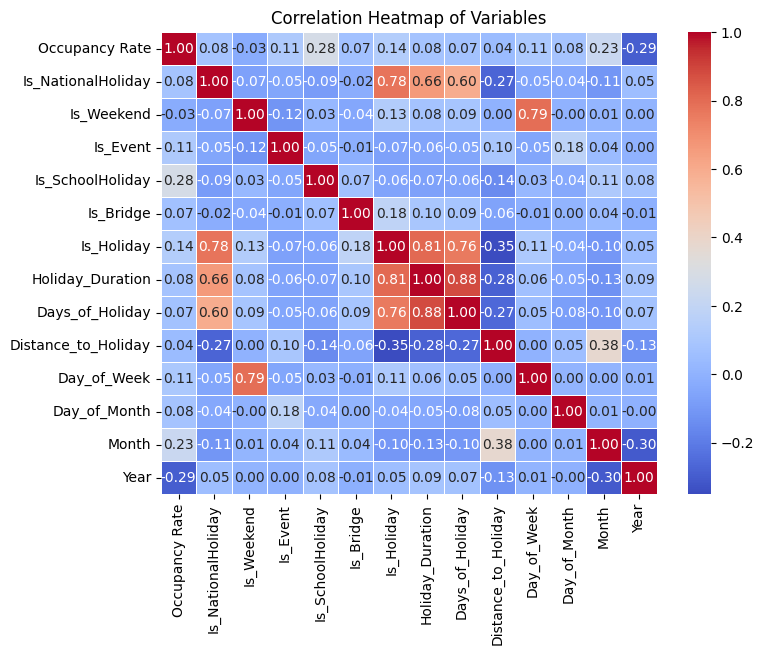

In [270]:
# Make a corrplot to see relation from each variable
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

corr = enrich.copy()

# convert Date from str to datetime
corr['Date'] = pd.to_datetime(corr['Date'])

# set Date as index
corr = corr.set_index('Date')

# sort by index
corr = corr.sort_index()

corrmatrix = corr.corr()
plt.figure(figsize=(8,6))
sns.heatmap(
    corrmatrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
)

plt.title('Correlation Heatmap of Variables')
plt.show()


# Prepare Dataset for Predictions

In [271]:
# Build Calendar

# Load holidays
holidays = pd.read_csv("holidays_info.csv")
holidays["Date"] = pd.to_datetime(holidays["Date"])

# events = holidays[holidays["Kind"] == "event"]

# find latest date in enrich than add one day to it
latest_date = pd.to_datetime(enrich['Date'].max()) + pd.Timedelta(days=1)

end_2026 = pd.Timestamp("2026-12-31")

future_cal = pd.date_range(start=latest_date, end=end_2026)

future_rows = []
for date in future_cal:
    # Check if date is holiday
    is_national_holiday = False
    is_weekend = date.weekday() >= 5
    is_school_holiday = False  # Will be determined from holidays_2026
    is_event = False  # Will be determined from holidays_2026

    holidays_info = holidays[holidays["Date"] == date]
    if not holidays_info.empty:
        is_national_holiday = holidays_info.iloc[0]["Kind"] in ["national", "joint"]
        is_school_holiday = holidays_info.iloc[0]["Kind"] == "school"
        is_event = holidays_info.iloc[0]["Kind"] == "event"

    future_rows.append({
        "Date": date,
        "Is_NationalHoliday": is_national_holiday,
        "Is_Weekend": is_weekend,
        "Is_Event": is_event,
        "Is_SchoolHoliday": is_school_holiday,     
    })

future = pd.DataFrame(future_rows)


seed_hol = (future['Is_NationalHoliday'].astype(bool) | future['Is_Weekend'].astype(bool)).to_numpy()
n = len(seed_hol)

left_seed  = np.r_[False, seed_hol[:-1]]
right_seed = np.r_[seed_hol[1:], False]
is_bridge = (~seed_hol) & left_seed & right_seed
future['Is_Bridge'] = is_bridge

is_nat   = future['Is_NationalHoliday'].to_numpy(dtype=bool)
is_we    = future['Is_Weekend'].to_numpy(dtype=bool)
is_br    = future['Is_Bridge'].to_numpy(dtype=bool)

left_hol_final_seed  = np.r_[False, (is_nat | is_br)[:-1]]
right_hol_final_seed = np.r_[(is_nat | is_br)[1:], False]
weekend_adjacent = is_we & (left_hol_final_seed | right_hol_final_seed)

is_holiday_final = is_nat | is_br | weekend_adjacent
future['Is_Holiday'] = is_holiday_final

block_id = (~is_holiday_final).cumsum() 
future['Holiday_Duration'] = 0
future['Days_of_Holiday'] = 0

mask = is_holiday_final
grp = pd.Series(block_id[mask]).groupby(block_id[mask])
sizes = grp.transform('size').to_numpy()

order_in_block = grp.cumcount() + 1

future.loc[mask, 'Holiday_Duration'] = sizes
future.loc[mask, 'Days_of_Holiday']  = order_in_block.to_numpy()

# Ambil array boolean hari libur (sudah termasuk bridge, sesuai definisi Anda)
is_hol = future["Is_Holiday"].to_numpy(dtype=bool)
n = len(future)
INF = 10**9

# Sweep ke depan (jarak dari libur terakhir)
dist_fwd = np.full(n, INF, dtype=int)
last = -INF
for i in range(n):
    if is_hol[i]:
        last = i
    dist_fwd[i] = i - last

# Sweep ke belakang (jarak ke libur berikutnya)
dist_bwd = np.full(n, INF, dtype=int)
last = INF
for i in range(n - 1, -1, -1):
    if is_hol[i]:
        last = i
    dist_bwd[i] = last - i

# Ambil jarak minimum; hari libur = 0
dist = np.minimum(dist_fwd, dist_bwd)
dist[is_hol] = 0
future["Distance_to_Holiday"] = dist

future['Day_of_Week']  = pd.to_datetime(future['Date']).dt.dayofweek
future['Day_of_Month'] = pd.to_datetime(future['Date']).dt.day
future['Month']        = pd.to_datetime(future['Date']).dt.month
future['Year']         = pd.to_datetime(future['Date']).dt.year


future


,Date,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year
0,2025-09-01,False,False,False,False,False,False,0,0,4,0,1,9,2025
1,2025-09-02,False,False,False,False,False,False,0,0,3,1,2,9,2025
2,2025-09-03,False,False,False,False,False,False,0,0,2,2,3,9,2025
3,2025-09-04,False,False,False,False,False,False,0,0,1,3,4,9,2025
4,2025-09-05,True,False,False,False,False,True,2,1,0,4,5,9,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,2026-12-27,False,True,False,True,False,False,0,0,1,6,27,12,2026
483,2026-12-28,False,False,False,True,False,False,0,0,2,0,28,12,2026
484,2026-12-29,False,False,False,True,False,False,0,0,3,1,29,12,2026
485,2026-12-30,False,False,False,True,False,False,0,0,4,2,30,12,2026


In [272]:
# Make a prediction
features = [
    "Is_NationalHoliday","Is_Weekend","Is_Event","Is_SchoolHoliday",
    "Is_Bridge","Is_Holiday",
    "Holiday_Duration","Days_of_Holiday","Distance_to_Holiday",
    "Day_of_Week","Day_of_Month","Month"
]

X_future = future[features].copy()

# pastikan boolean → int
for c in X_future.columns:
    if X_future[c].dtype == bool:
        X_future[c] = X_future[c].astype(int)
    if X[c].dtype == object and set(pd.unique(X[c])) <= {"True","False"}:
        X[c] = X[c].map({"False":0, "True":1}).astype(int)

future["Predicted_Occupancy"] = rf.predict(X_future)
future

,Date,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year,Predicted_Occupancy
0,2025-09-01,False,False,False,False,False,False,0,0,4,0,1,9,2025,0.381296
1,2025-09-02,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.364237
2,2025-09-03,False,False,False,False,False,False,0,0,2,2,3,9,2025,0.494786
3,2025-09-04,False,False,False,False,False,False,0,0,1,3,4,9,2025,0.482944
4,2025-09-05,True,False,False,False,False,True,2,1,0,4,5,9,2025,0.567932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,2026-12-27,False,True,False,True,False,False,0,0,1,6,27,12,2026,0.730164
483,2026-12-28,False,False,False,True,False,False,0,0,2,0,28,12,2026,0.738621
484,2026-12-29,False,False,False,True,False,False,0,0,3,1,29,12,2026,0.794495
485,2026-12-30,False,False,False,True,False,False,0,0,4,2,30,12,2026,0.855485


# Analyze Occ-ARR

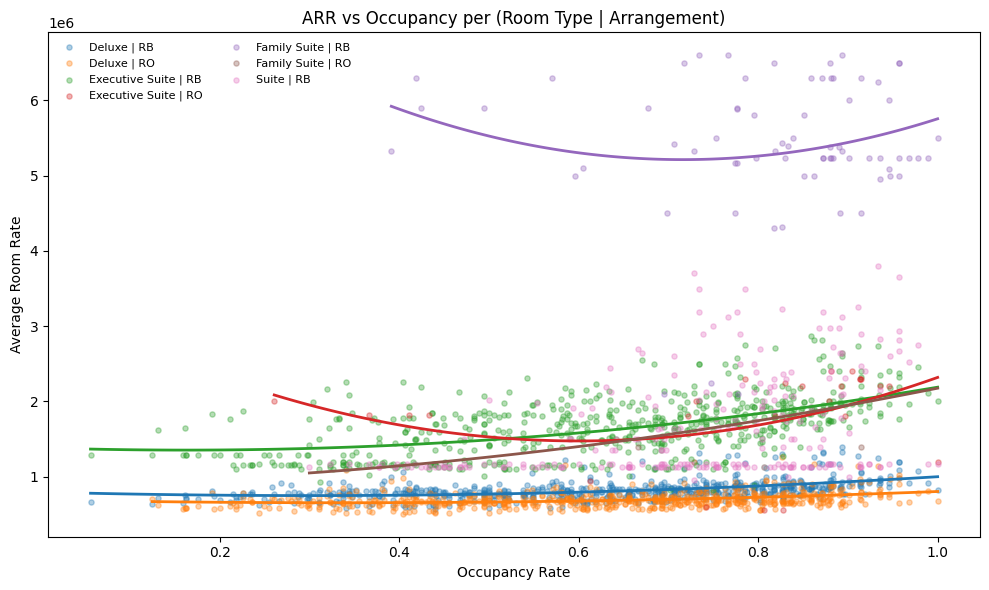

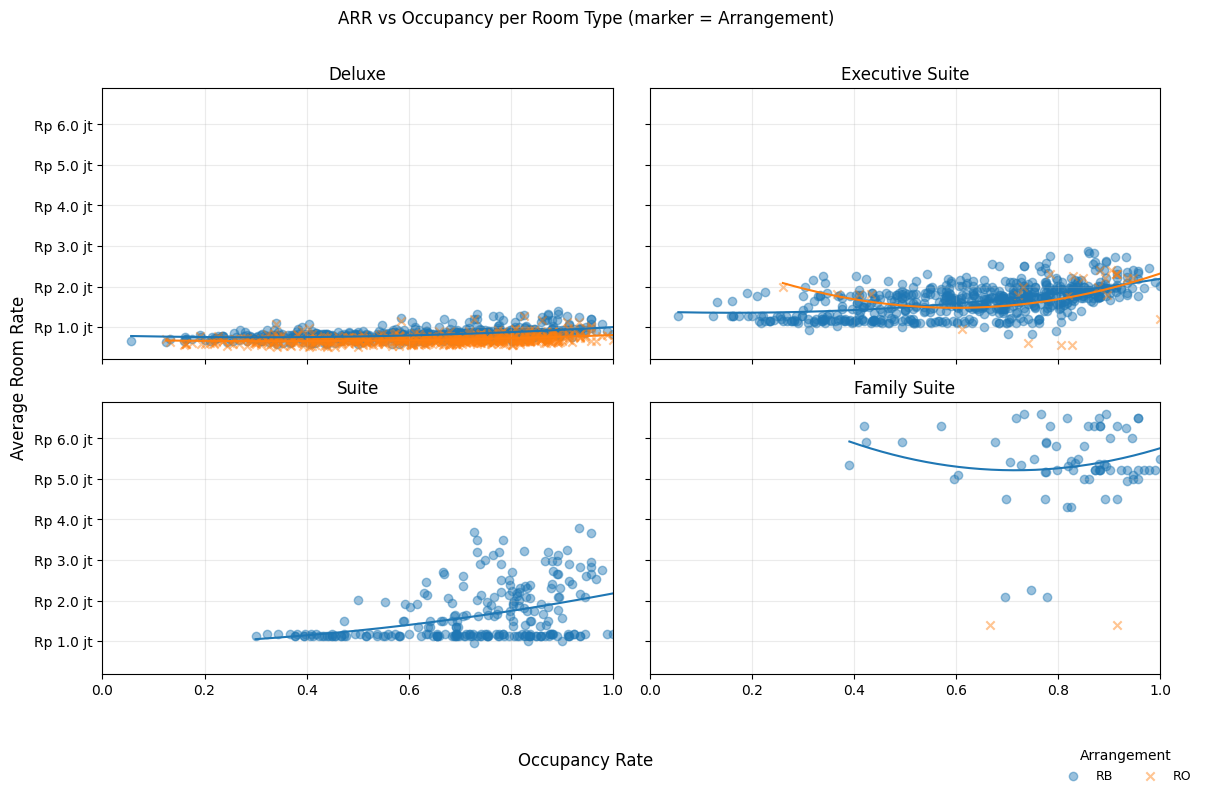

In [326]:
# Analisis Occ-ARR
priceanalysis = df.copy()
priceanalysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

priceanalysis['Occupancy Rate'] = priceanalysis['Occupancy Rate'].astype(float).clip(1e-6, 1-1e-6)
priceanalysis['Average Room Rate'] = priceanalysis['Average Room Rate'].astype(float)

priceanalysis["RT_ARR"] = priceanalysis["Room Type"].astype(str) + " | " + priceanalysis["Arrangement"].astype(str)
# scatter + poly deg=2 per kombinasi
plt.figure(figsize=(10,6))

# warna otomatis per kombinasi
for (key, g) in priceanalysis.groupby("RT_ARR"):
    x = g["Occupancy Rate"].values
    y = g["Average Room Rate"].values
    # scatter
    plt.scatter(x, y, s=14, alpha=0.35, label=key)
    # fit polinomial derajat-2 (jika titik cukup)
    if len(g) >= 6:
        try:
            coefs = np.polyfit(x, y, deg=2)   # y ≈ a*x^2 + b*x + c
            xx = np.linspace(x.min(), x.max(), 120)
            yy = np.polyval(coefs, xx)
            plt.plot(xx, yy, linewidth=2)
        except np.linalg.LinAlgError:
            pass

plt.title("ARR vs Occupancy per (Room Type | Arrangement)")
plt.xlabel("Occupancy Rate")
plt.ylabel("Average Room Rate")
plt.legend(ncols=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

markers = {"RB": "o", "RO": "x"}
alpha_pts = 0.45
deg_fit   = 2

# room type yang akan diplot (maks 4 untuk grid 2x2)
roomtypes_all = priceanalysis["Room Type"].unique().tolist()
roomtypes = roomtypes_all[:4]

# siapkan batas y global (konsisten di semua subplot)
mask = priceanalysis["Room Type"].isin(roomtypes)
y_all = priceanalysis.loc[mask, "Average Room Rate"].to_numpy()
ymin, ymax = np.nanmin(y_all), np.nanmax(y_all)
pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
ymin_glob, ymax_glob = ymin - pad, ymax + pad

# formatter: tampilkan Rp … jt (juta)
def rupiah_juta(x, pos):
    return f"Rp {x/1_000_000:.1f} jt"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, rt in zip(axes, roomtypes):
    sub = priceanalysis[priceanalysis["Room Type"] == rt].copy()

    # scatter per arrangement + garis fit per arrangement
    for arr, mk in markers.items():
        g = sub[sub["Arrangement"] == arr]
        if g.empty:
            continue

        ax.scatter(g["Occupancy Rate"], g["Average Room Rate"],
                   marker=mk, alpha=alpha_pts, label=arr)

        # garis tren (poly deg=2) hanya jika data cukup
        if len(g) >= 8:
            x = g["Occupancy Rate"].to_numpy()
            y = g["Average Room Rate"].to_numpy()
            xs = np.linspace(x.min(), x.max(), 200)
            p  = np.poly1d(np.polyfit(x, y, deg_fit))
            ax.plot(xs, p(xs))

    ax.set_title(f"{rt}")
    ax.grid(True, alpha=0.25)
    ax.set_ylim(ymin_glob, ymax_glob)
    ax.yaxis.set_major_formatter(FuncFormatter(rupiah_juta))
    ax.set_xlim(0, 1)  # occupancy 0–1

# label sumbu bersama
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)
fig.supxlabel("Occupancy Rate")
fig.supylabel("Average Room Rate")

# legenda gabungan (arrangement)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title="Arrangement",
           loc="lower center", bbox_to_anchor=(0.95, -0.02),
           ncols=len(labels), frameon=False, fontsize=9, title_fontsize=10)

# turunkan sedikit suptitle agar tidak tertimpa
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)

plt.tight_layout(rect=[0,0.04,1,0.95])
plt.show()

In [415]:
rt='Family Suite'
# Deluxe, Executive Suite, Suite, Family Suite

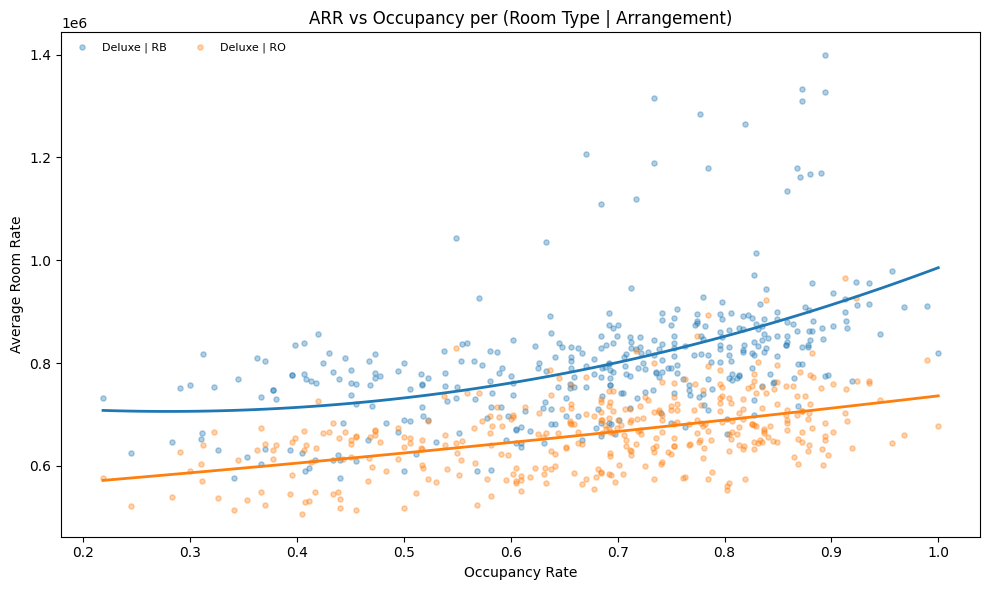

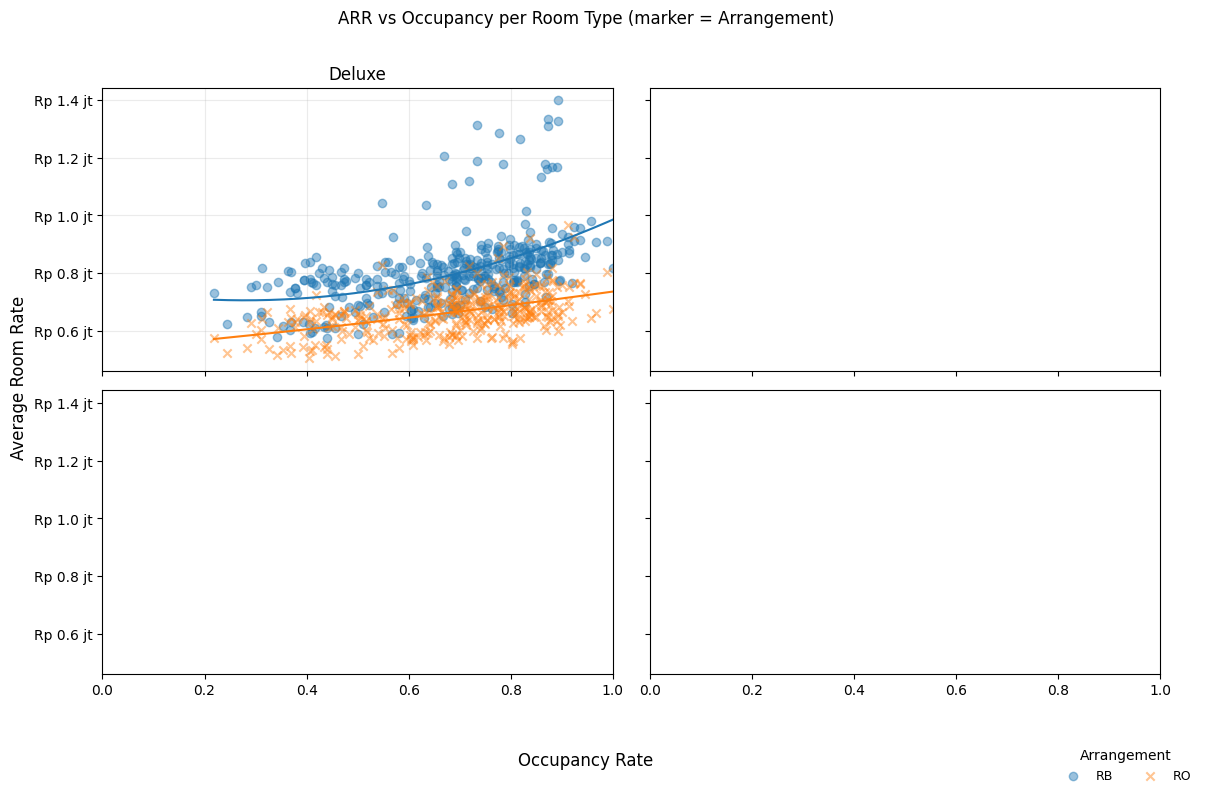

In [349]:
# Analisis Occ-ARR (2024)
priceanalysis = df.copy()
priceanalysis = priceanalysis[priceanalysis['Date'] < '2025-01-01']
priceanalysis = priceanalysis[priceanalysis['Room Type'] == rt]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

priceanalysis['Occupancy Rate'] = priceanalysis['Occupancy Rate'].astype(float).clip(1e-6, 1-1e-6)
priceanalysis['Average Room Rate'] = priceanalysis['Average Room Rate'].astype(float)

priceanalysis["RT_ARR"] = priceanalysis["Room Type"].astype(str) + " | " + priceanalysis["Arrangement"].astype(str)
# scatter + poly deg=2 per kombinasi
plt.figure(figsize=(10,6))

# warna otomatis per kombinasi
for (key, g) in priceanalysis.groupby("RT_ARR"):
    x = g["Occupancy Rate"].values
    y = g["Average Room Rate"].values
    # scatter
    plt.scatter(x, y, s=14, alpha=0.35, label=key)
    # fit polinomial derajat-2 (jika titik cukup)
    if len(g) >= 6:
        try:
            coefs = np.polyfit(x, y, deg=2)   # y ≈ a*x^2 + b*x + c
            xx = np.linspace(x.min(), x.max(), 120)
            yy = np.polyval(coefs, xx)
            plt.plot(xx, yy, linewidth=2)
        except np.linalg.LinAlgError:
            pass

plt.title("ARR vs Occupancy per (Room Type | Arrangement)")
plt.xlabel("Occupancy Rate")
plt.ylabel("Average Room Rate")
plt.legend(ncols=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

markers = {"RB": "o", "RO": "x"}
alpha_pts = 0.45
deg_fit   = 2

# room type yang akan diplot (maks 4 untuk grid 2x2)
roomtypes_all = priceanalysis["Room Type"].unique().tolist()
roomtypes = roomtypes_all[:4]

# siapkan batas y global (konsisten di semua subplot)
mask = priceanalysis["Room Type"].isin(roomtypes)
y_all = priceanalysis.loc[mask, "Average Room Rate"].to_numpy()
ymin, ymax = np.nanmin(y_all), np.nanmax(y_all)
pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
ymin_glob, ymax_glob = ymin - pad, ymax + pad

# formatter: tampilkan Rp … jt (juta)
def rupiah_juta(x, pos):
    return f"Rp {x/1_000_000:.1f} jt"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, rt in zip(axes, roomtypes):
    sub = priceanalysis[priceanalysis["Room Type"] == rt].copy()

    # scatter per arrangement + garis fit per arrangement
    for arr, mk in markers.items():
        g = sub[sub["Arrangement"] == arr]
        if g.empty:
            continue

        ax.scatter(g["Occupancy Rate"], g["Average Room Rate"],
                   marker=mk, alpha=alpha_pts, label=arr)

        # garis tren (poly deg=2) hanya jika data cukup
        if len(g) >= 8:
            x = g["Occupancy Rate"].to_numpy()
            y = g["Average Room Rate"].to_numpy()
            xs = np.linspace(x.min(), x.max(), 200)
            p  = np.poly1d(np.polyfit(x, y, deg_fit))
            ax.plot(xs, p(xs))

    ax.set_title(f"{rt}")
    ax.grid(True, alpha=0.25)
    ax.set_ylim(ymin_glob, ymax_glob)
    ax.yaxis.set_major_formatter(FuncFormatter(rupiah_juta))
    ax.set_xlim(0, 1)  # occupancy 0–1

# label sumbu bersama
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)
fig.supxlabel("Occupancy Rate")
fig.supylabel("Average Room Rate")

# legenda gabungan (arrangement)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title="Arrangement",
           loc="lower center", bbox_to_anchor=(0.95, -0.02),
           ncols=len(labels), frameon=False, fontsize=9, title_fontsize=10)

# turunkan sedikit suptitle agar tidak tertimpa
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)

plt.tight_layout(rect=[0,0.04,1,0.95])
plt.show()

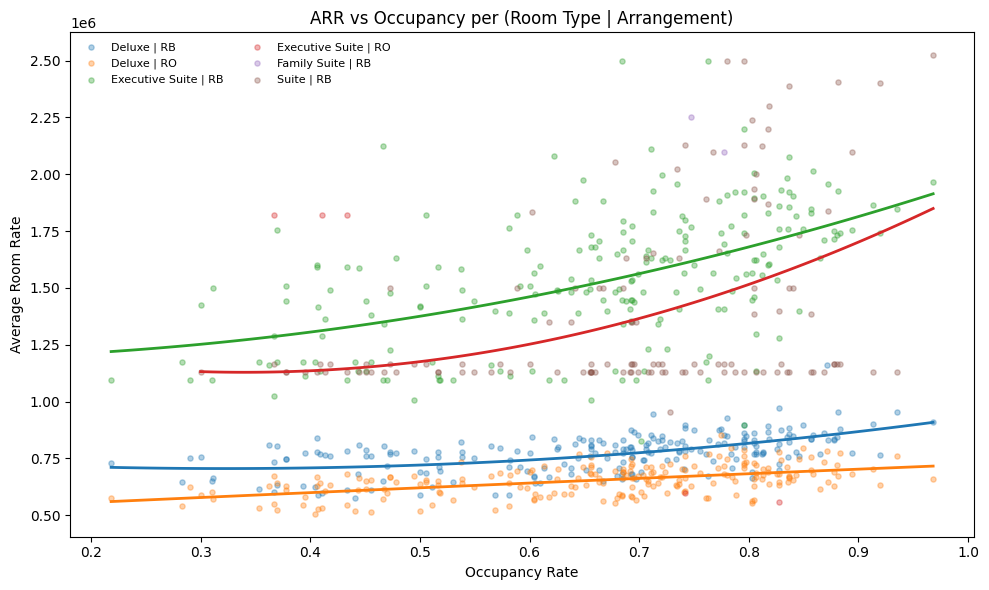

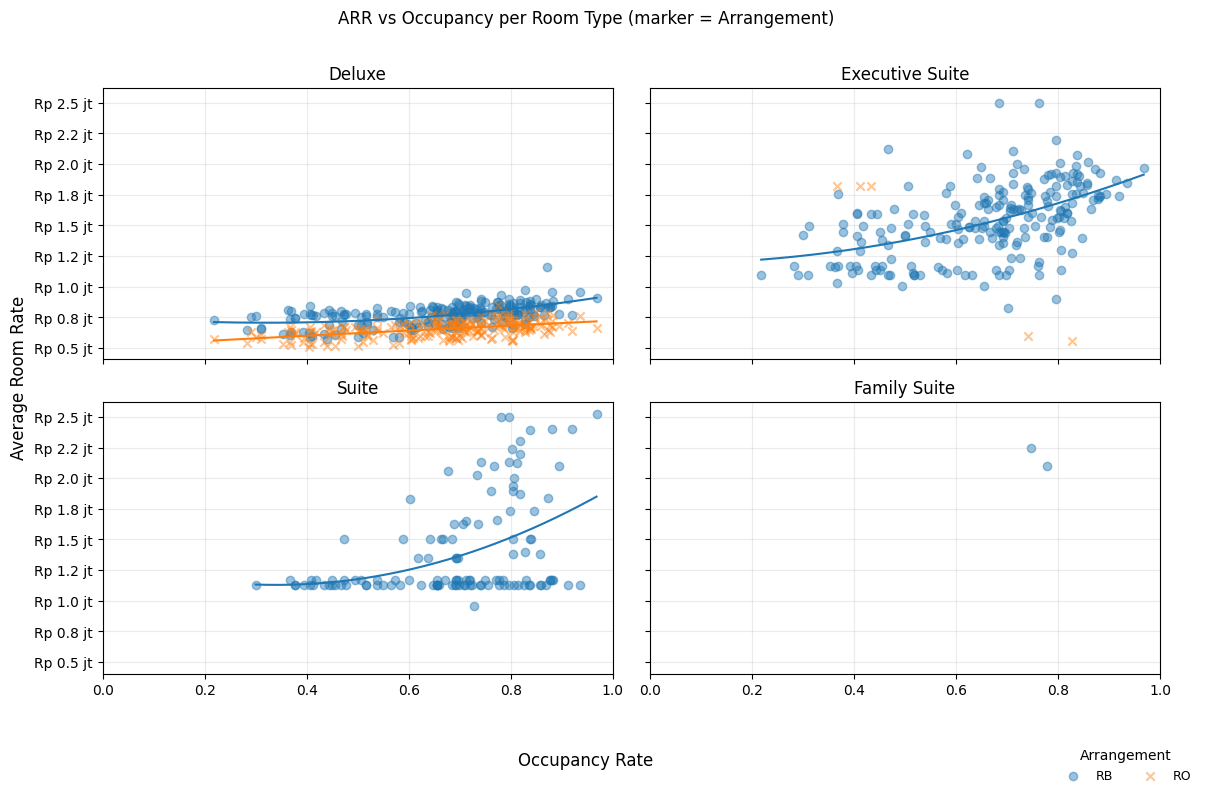

In [423]:
# Analisis Occ-ARR (2024 remove outliers - Deluxe)
priceanalysis = df.copy()
priceanalysis = priceanalysis[priceanalysis['Date'] < '2025-01-01']
#priceanalysis = priceanalysis[priceanalysis['Room Type'] == rt]

priceanalysis = priceanalysis[
        (~priceanalysis['Is_Holiday']) &
        (~priceanalysis['Is_Weekend']) &
        (~priceanalysis['Is_Event']) &
        (~priceanalysis['Is_SchoolHoliday'])
    ]
    
# Remove outliers using IQR method
Q1 = priceanalysis["Average Room Rate"].quantile(0.25)
Q3 = priceanalysis["Average Room Rate"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

priceanalysis = priceanalysis[
    (priceanalysis["Average Room Rate"] >= lower_bound) & 
    (priceanalysis["Average Room Rate"] <= upper_bound)
]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

priceanalysis['Occupancy Rate'] = priceanalysis['Occupancy Rate'].astype(float).clip(1e-6, 1-1e-6)
priceanalysis['Average Room Rate'] = priceanalysis['Average Room Rate'].astype(float)

priceanalysis["RT_ARR"] = priceanalysis["Room Type"].astype(str) + " | " + priceanalysis["Arrangement"].astype(str)
# scatter + poly deg=2 per kombinasi
plt.figure(figsize=(10,6))

# warna otomatis per kombinasi
for (key, g) in priceanalysis.groupby("RT_ARR"):
    x = g["Occupancy Rate"].values
    y = g["Average Room Rate"].values
    # scatter
    plt.scatter(x, y, s=14, alpha=0.35, label=key)
    # fit polinomial derajat-2 (jika titik cukup)
    if len(g) >= 6:
        try:
            coefs = np.polyfit(x, y, deg=2)   # y ≈ a*x^2 + b*x + c
            xx = np.linspace(x.min(), x.max(), 120)
            yy = np.polyval(coefs, xx)
            plt.plot(xx, yy, linewidth=2)
        except np.linalg.LinAlgError:
            pass

plt.title("ARR vs Occupancy per (Room Type | Arrangement)")
plt.xlabel("Occupancy Rate")
plt.ylabel("Average Room Rate")
plt.legend(ncols=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

markers = {"RB": "o", "RO": "x"}
alpha_pts = 0.45
deg_fit   = 2

# room type yang akan diplot (maks 4 untuk grid 2x2)
roomtypes_all = priceanalysis["Room Type"].unique().tolist()
roomtypes = roomtypes_all[:4]

# siapkan batas y global (konsisten di semua subplot)
mask = priceanalysis["Room Type"].isin(roomtypes)
y_all = priceanalysis.loc[mask, "Average Room Rate"].to_numpy()
ymin, ymax = np.nanmin(y_all), np.nanmax(y_all)
pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
ymin_glob, ymax_glob = ymin - pad, ymax + pad

# formatter: tampilkan Rp … jt (juta)
def rupiah_juta(x, pos):
    return f"Rp {x/1_000_000:.1f} jt"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, rt in zip(axes, roomtypes):
    sub = priceanalysis[priceanalysis["Room Type"] == rt].copy()

    # scatter per arrangement + garis fit per arrangement
    for arr, mk in markers.items():
        g = sub[sub["Arrangement"] == arr]
        if g.empty:
            continue

        ax.scatter(g["Occupancy Rate"], g["Average Room Rate"],
                   marker=mk, alpha=alpha_pts, label=arr)

        # garis tren (poly deg=2) hanya jika data cukup
        if len(g) >= 8:
            x = g["Occupancy Rate"].to_numpy()
            y = g["Average Room Rate"].to_numpy()
            xs = np.linspace(x.min(), x.max(), 200)
            p  = np.poly1d(np.polyfit(x, y, deg_fit))
            ax.plot(xs, p(xs))

    ax.set_title(f"{rt}")
    ax.grid(True, alpha=0.25)
    ax.set_ylim(ymin_glob, ymax_glob)
    ax.yaxis.set_major_formatter(FuncFormatter(rupiah_juta))
    ax.set_xlim(0, 1)  # occupancy 0–1

# label sumbu bersama
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)
fig.supxlabel("Occupancy Rate")
fig.supylabel("Average Room Rate")

# legenda gabungan (arrangement)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title="Arrangement",
           loc="lower center", bbox_to_anchor=(0.95, -0.02),
           ncols=len(labels), frameon=False, fontsize=9, title_fontsize=10)

# turunkan sedikit suptitle agar tidak tertimpa
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)

plt.tight_layout(rect=[0,0.04,1,0.95])
plt.show()

# Predictions

In [411]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def subset_and_clean(df, room_type, arrangement, iqr_k=1.5):
    pa = df.copy()
    pa = pa[(pa['Date'] >= '2024-01-01') & (pa['Date'] < '2025-01-01')]
    pa = pa[(pa['Room Type'] == room_type) & (pa['Arrangement'] == arrangement)].copy()
    pa = pa[
        (~pa['Is_Holiday']) &
        (~pa['Is_Weekend']) &
        (~pa['Is_Event']) &
        (~pa['Is_SchoolHoliday'])
    ].copy()
    Q1 = pa['Average Room Rate'].quantile(0.25)
    Q3 = pa['Average Room Rate'].quantile(0.75)
    IQR = Q3 - Q1
    lb, ub = Q1 - iqr_k*IQR, Q3 + iqr_k*IQR
    pa = pa[(pa['Average Room Rate'] >= lb) & (pa['Average Room Rate'] <= ub)].copy()

    pa['Occupancy Rate']   = pa['Occupancy Rate'].astype(float).clip(1e-6, 1-1e-6)
    pa['Average Room Rate'] = pa['Average Room Rate'].astype(float)
    return pa

coef_map = {}
records  = []

pairs = df[['Room Type','Arrangement']].dropna().drop_duplicates().sort_values(['Room Type','Arrangement'])
for rt, arr in pairs.itertuples(index=False):
    clean = subset_and_clean(df, room_type=rt, arrangement=arr, iqr_k=1.5)
    x = clean['Occupancy Rate'].to_numpy(); y = clean['Average Room Rate'].to_numpy()
    if len(x) < 6 or np.nanstd(x) == 0:
        continue
    coefs = np.polyfit(x, y, deg=2)
    coef_map[(rt,arr)] = coefs
    records.append({"Room Type": rt, "Arrangement": arr,
                    "a": coefs[0], "b": coefs[1], "c": coefs[2],
                    "n_points": len(x),
                    "occ_min": float(np.min(x)), "occ_max": float(np.max(x)),
                    "arr_med": float(np.median(y))
                    })

coef_df = pd.DataFrame(records).sort_values(['Room Type','Arrangement']).reset_index(drop=True)

future_ = future.copy()
future_['__k'] = 1
pairs_  = pairs.copy()
pairs_['__k'] = 1

predictions = (
    future_.merge(pairs_, on='__k', how='outer')
           .drop(columns='__k')
)

predictions = predictions.merge(
    coef_df, on=["Room Type", "Arrangement"], how="left"
)

predictions["occ_used"] = predictions["Predicted_Occupancy"].astype(float).clip(1e-6, 1-1e-6)

predictions["ARR_rec"] = predictions.eval("a * occ_used**2 + b * occ_used + c")

#drop column Year
predictions = predictions.drop(columns=['Year', 'Month','Is_Holiday', 'Day_of_Week', 'Day_of_Month'])
predictions

,Date,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Bridge,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Predicted_Occupancy,...,Arrangement,a,b,c,n_points,occ_min,occ_max,arr_med,occ_used,ARR_rec
0,2025-09-01,False,False,False,False,False,0,0,4,0.381296,...,RB,4.096464e+05,-2.310061e+05,7.358212e+05,213.0,0.218391,0.968085,7.792558e+05,0.381296,7.072966e+05
1,2025-09-01,False,False,False,False,False,0,0,4,0.381296,...,RO,-1.185314e+04,2.183191e+05,5.145034e+05,213.0,0.218391,0.968085,6.600882e+05,0.381296,5.960244e+05
2,2025-09-01,False,False,False,False,False,0,0,4,0.381296,...,RB,9.611848e+05,-2.427764e+05,1.249329e+06,214.0,0.218391,0.968085,1.537585e+06,0.381296,1.296502e+06
3,2025-09-01,False,False,False,False,False,0,0,4,0.381296,...,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381296,NaN
4,2025-09-01,False,False,False,False,False,0,0,4,0.381296,...,RB,-1.393164e+06,1.403837e+07,-6.140182e+06,8.0,0.698925,0.968085,5.229000e+06,0.381296,-9.899509e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3404,2026-12-31,False,False,False,True,False,0,0,5,0.881263,...,RB,9.611848e+05,-2.427764e+05,1.249329e+06,214.0,0.218391,0.968085,1.537585e+06,0.881263,1.781859e+06
3405,2026-12-31,False,False,False,True,False,0,0,5,0.881263,...,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.881263,NaN
3406,2026-12-31,False,False,False,True,False,0,0,5,0.881263,...,RB,-1.393164e+06,1.403837e+07,-6.140182e+06,8.0,0.698925,0.968085,5.229000e+06,0.881263,5.149354e+06
3407,2026-12-31,False,False,False,True,False,0,0,5,0.881263,...,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.881263,NaN


In [424]:
#export predictions as csv
import pandas as pd

predictions.to_csv('predictions.csv', index=False)

In [ ]:
'''
# calculate average ARR_rec per Room Type - Arrangement
print(f"Deluxe: {predictions[predictions['Room Type'] == 'Deluxe'].groupby('Arrangement')['ARR_rec'].mean()}")
print(f"Executive Suite: {predictions[predictions['Room Type'] == 'Executive Suite'].groupby('Arrangement')['ARR_rec'].mean()}")
print(f"Suite: {predictions[predictions['Room Type'] == 'Suite'].groupby('Arrangement')['ARR_rec'].mean()}")
print(f"Family Suite: {predictions[predictions['Room Type'] == 'Family Suite'].groupby('Arrangement')['ARR_rec'].mean()}")
'''

# .describe per Room Type - Arrangement
print(f"Deluxe: {predictions[predictions['Room Type'] == 'Deluxe'].groupby('Arrangement')['Predicted_Occupancy'].describe()}")
print(f"Deluxe: {predictions[predictions['Room Type'] == 'Deluxe'].groupby('Arrangement')['ARR_rec'].describe()}")
print(f"Deluxe: {predictions[predictions['Room Type'] == 'Executive Suite'].groupby('Arrangement')['Predicted_Occupancy'].describe()}")
print(f"Executive Suite: {predictions[predictions['Room Type'] == 'Executive Suite'].groupby('Arrangement')['ARR_rec'].describe()}")
print(f"Deluxe: {predictions[predictions['Room Type'] == 'Suite'].groupby('Arrangement')['Predicted_Occupancy'].describe()}")
print(f"Suite: {predictions[predictions['Room Type'] == 'Suite'].groupby('Arrangement')['ARR_rec'].describe()}")
print(f"Deluxe: {predictions[predictions['Room Type'] == 'Family Suite'].groupby('Arrangement')['Predicted_Occupancy'].describe()}")
print(f"Family Suite: {predictions[predictions['Room Type'] == 'Family Suite'].groupby('Arrangement')['ARR_rec'].describe()}")

Deluxe:              count      mean       std       min       25%      50%       75%  \
Arrangement                                                                     
RB           487.0  0.646798  0.143931  0.281494  0.519271  0.66053  0.773406   
RO           487.0  0.646798  0.143931  0.281494  0.519271  0.66053  0.773406   

                  max  
Arrangement            
RB           0.909193  
RO           0.909193  
Deluxe:              count           mean           std            min            25%  \
Arrangement                                                                     
RB           487.0  766250.448386  41696.659239  703254.261333  726324.391820   
RO           487.0  650508.026312  29278.440382  575019.660838  624674.003347   

                       50%            75%            max  
Arrangement                                               
RB           761963.249074  802192.495499  864418.774724  
RO           653538.101168  676262.678311  703199.390043  
De

In [410]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3409 entries, 0 to 3408
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 3409 non-null   datetime64[ns]
 1   Is_NationalHoliday   3409 non-null   bool          
 2   Is_Weekend           3409 non-null   bool          
 3   Is_Event             3409 non-null   bool          
 4   Is_SchoolHoliday     3409 non-null   bool          
 5   Is_Bridge            3409 non-null   bool          
 6   Holiday_Duration     3409 non-null   int64         
 7   Days_of_Holiday      3409 non-null   int64         
 8   Distance_to_Holiday  3409 non-null   int64         
 9   Predicted_Occupancy  3409 non-null   float64       
 10  Room Type            3409 non-null   object        
 11  Arrangement          3409 non-null   object        
 12  a                    2435 non-null   float64       
 13  b                    2435 non-nul